# Analyzing a simulated signal

The `pymultifracs` package allows us to perform fractal and multifractal analysis of signals

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
sns.set_theme(style="darkgrid")
sns.set_context('paper')

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Generating a signal

Let us first generate a Multifractal Random Walk with parameters $H = 0.8$ and $\lambda=\sqrt{0.05}$

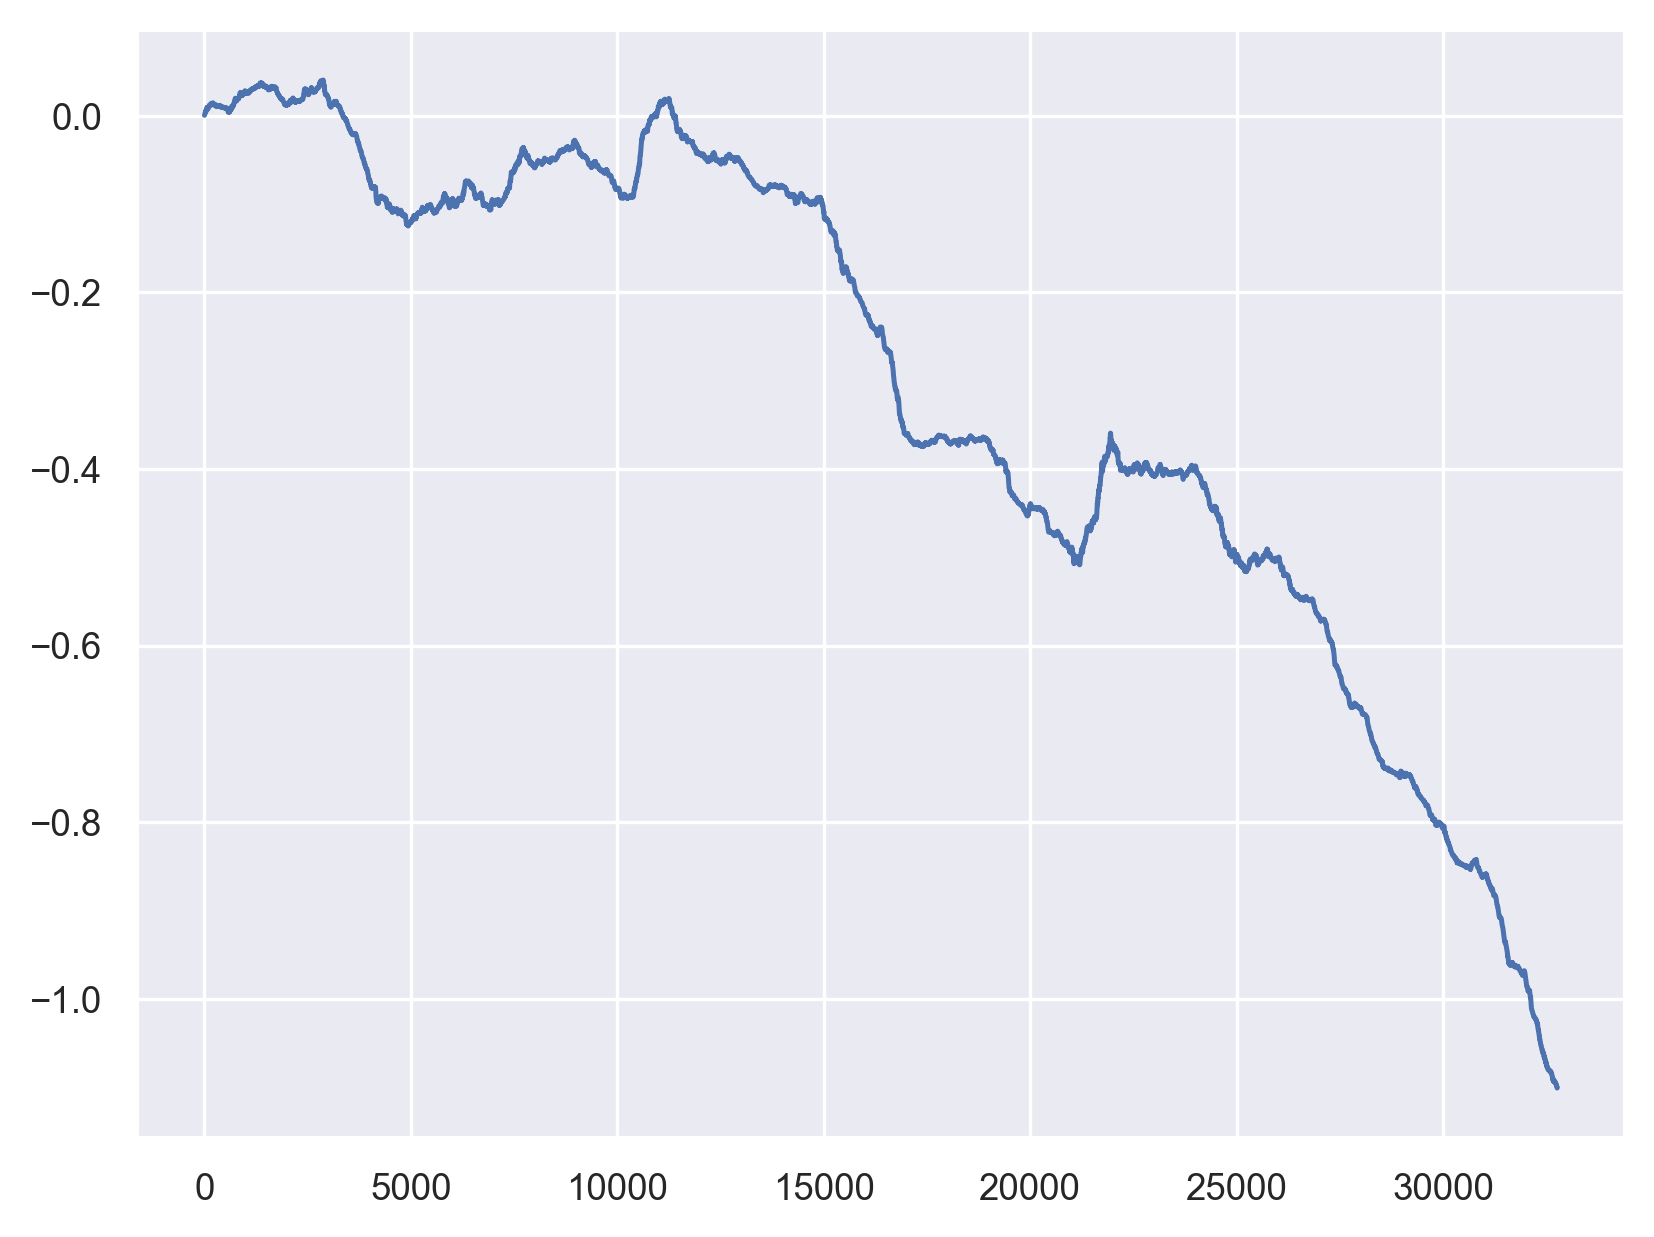

In [3]:
from pymultifracs.simul import mrw

X = mrw(shape=2**15, H=0.8, lam=np.sqrt(.05), L=2**15)
plt.plot(X)

## Second order analysis

Second order analysis is done with the `psd` module

The sampling frequency `fs` is necessary in order to correctly label the frequency axis

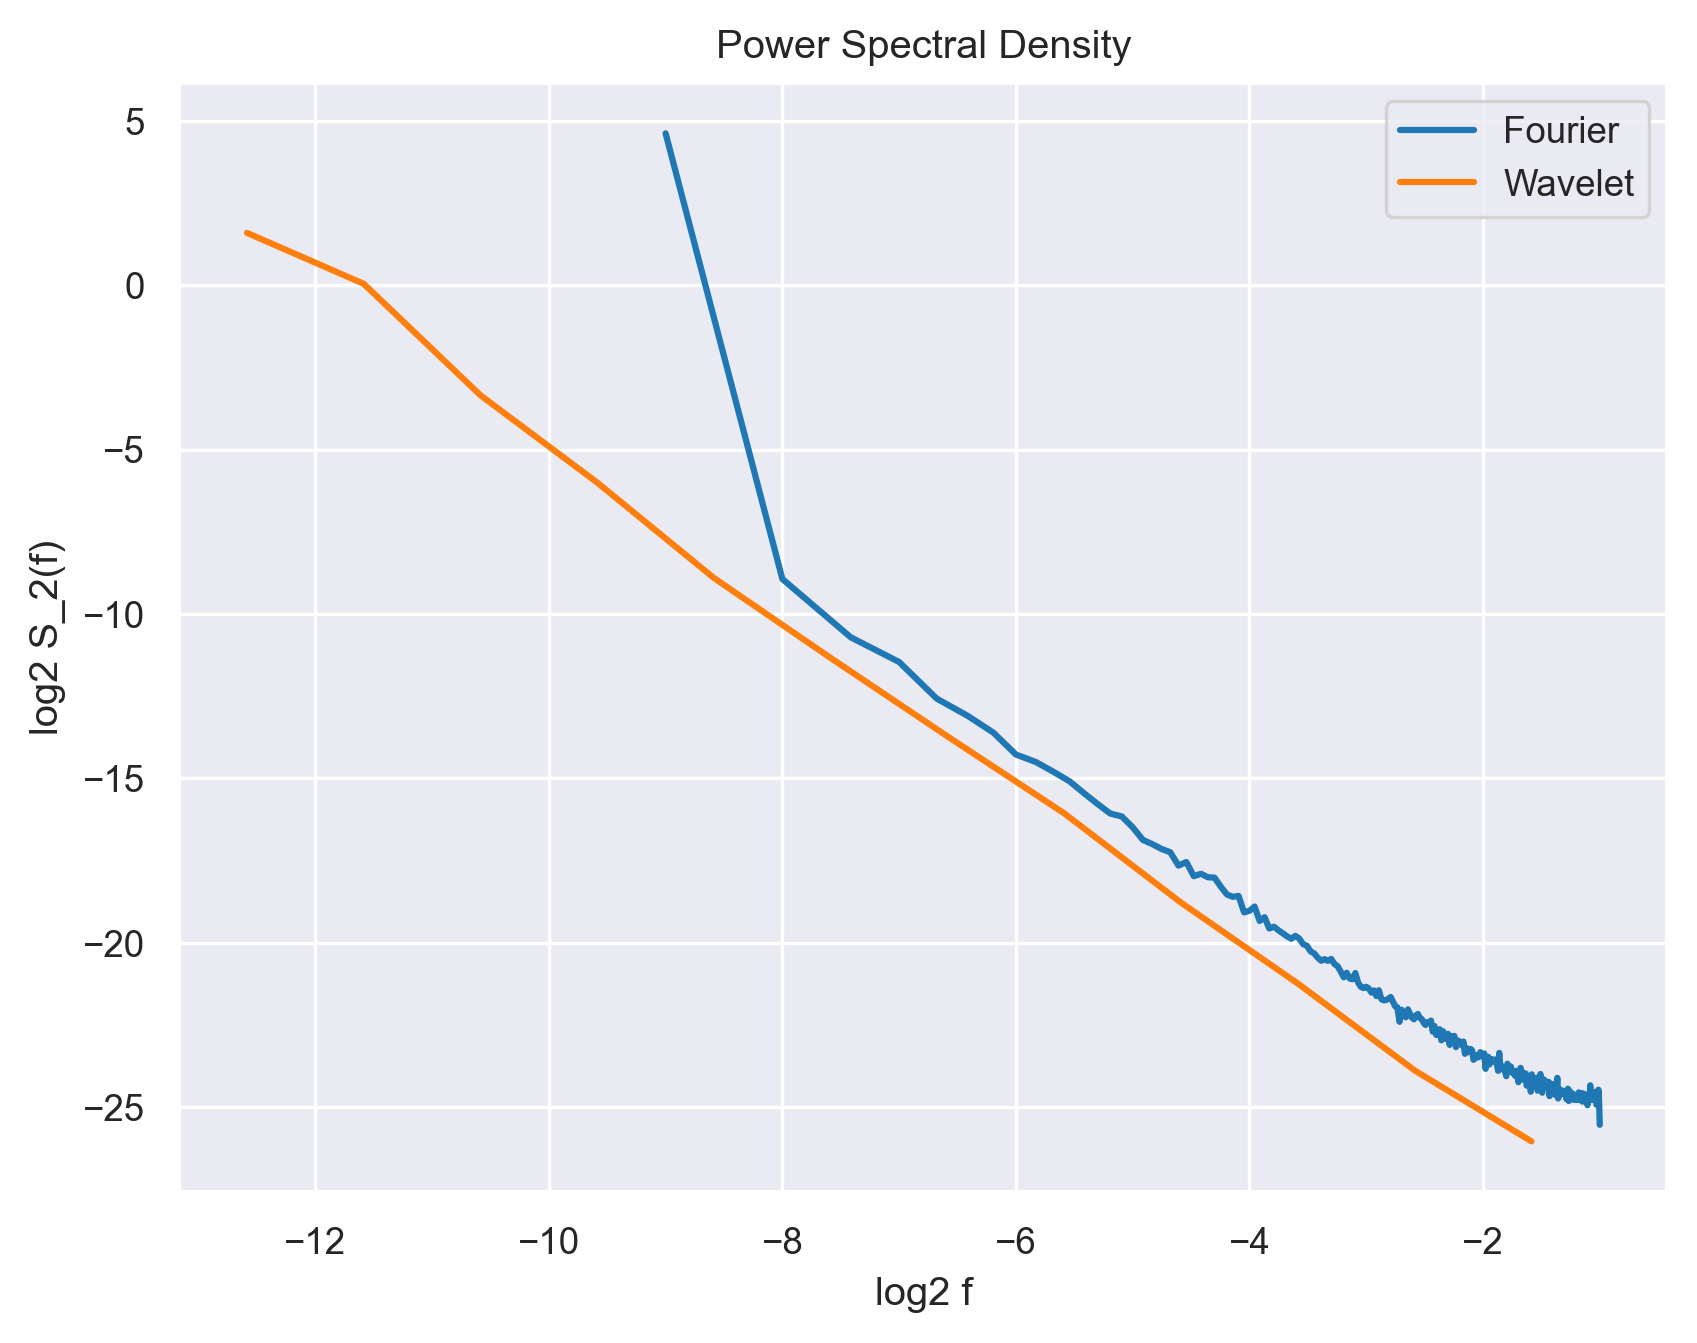

In [4]:
from pymultifracs.viz import plot_psd

plot_psd(X, 1, n_fft=512)

The Fourier-based PSD estimation is done using the Welch estimator.

The arguments relative the Fourier-based estimation are:
* `n_fft`: length of the FFT used
* `seg_size`: size of the segment used in the Welch estimation

The Wavelet-based estimation is done using wavelet analysis based on the Daubechies wavelet.

The number of vanishing moments can be controlled using the `n_moments` argument

## Wavelet Transform

Wavelet transform is performed in the package using the `wavelet_analysis` function

Parameters:

- `wt_name`: The discrete wavelet type used

- `j2`: The largest scale to analyze, by default None which means that the analysis is carried to the coarsest possible temporal scale $j$

- `normalization`: Normalization norm for the wavelet coefficients. Defaults to 1 which is appropriate for scale invariance analysis.

Multiple signals may be passed as a 2-dimensional array of shape `(n_samples, n_signals)`

In [5]:
from pymultifracs import wavelet_analysis

WT = wavelet_analysis(X, wt_name='db3', j2=None, normalization=1)

The output is a `WaveletDec` object, which contains the wavelet transform of the time series.

It may be visualized using the `plot` method, specifying `j1` and `j2`, the lower and upper bound on the scales temporal scales displayed, respectively.

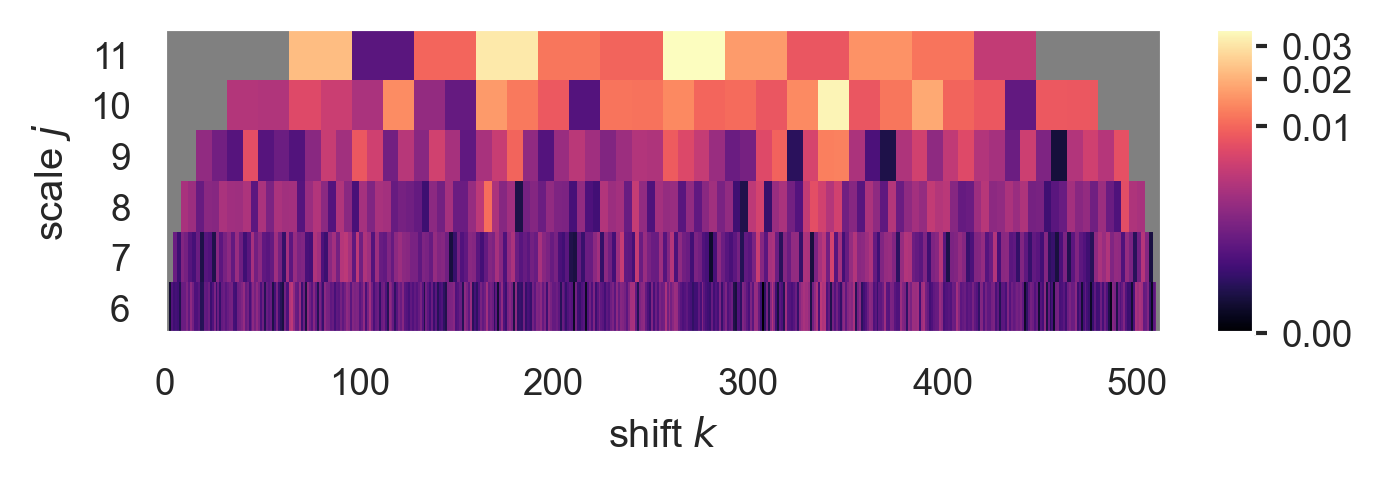

In [6]:
WT.plot(j1=6, j2=11)

Fractional integration is carried out using the `.integrate` method:

In [7]:
WT_int = WT.integrate(.5)

Multi-resolution quantities derived from the wavelet transform can be obtained using the associated methods `get_leaders` and `get_wse`:

In [8]:
WTL = WT.get_leaders(p_exp=np.inf)
WTpL = WT.get_leaders(p_exp=2)
WSE = WT.get_wse(theta=0.5)

## Multifractal Analysis

Multifractal analysis relies on regressing statistical quantities computed at different temporal scales $j$. The range of scales over which the regression is performed is specified using its bounds $[j_1, j_2]$.

The `scaling_ranges` argument in any function needs to be a list of tuples indicating the bounds. Multiple scaling ranges may be regressed at once by providing multiple tuples:

In [9]:
scaling_ranges = [(2, 8), (3, 8)]

In order for the analysis to be meaningful under the chosen multifractal formalism (wavelet coefficient, wavelet (p-)leader, etc.) it may be necessary to verify a minimum regularity condition.
The method `.check_regularity` is available with all multi-resolution quantities, and takes the `scaling_ranges` as an argument:

In [10]:
WT.check_regularity(scaling_ranges)
WTL.check_regularity(scaling_ranges)
WTpL.check_regularity(scaling_ranges)
WSE.check_regularity(scaling_ranges)

In case the minimal regularity is too low, it may be necessary to fractionally integrate the time series.

A simple approach is provided in the `.auto_integrate` method, which will try to find a fractional integration coefficient large enough that all signals may be analyzed, and return the properly integrated multi-resolution quantity

In [11]:
WTpL = WTpL.auto_integrate(scaling_ranges)

Multifractal analysis is carried out using the `mfa` function.

Parameters:

- `weighted`: whether the linear regressions should be weighted. Defaults to None, which means no weighting is performed. `"Nj"` indicates that the weights are determined from the number of coefficients at each scale.

- `q`: list of moments 

- `n_cumul`: maximum order of log-cumulants $c_m$ to compute

Ouptput: `MFractalVar` object, which contains:

- `structure`: the structure functions and associated exponents

- `cumulants`: the cumulant scaling functions and log-cumulants

- `spectrum`: the multifractal spectrum

**Note**: by default, `mfa` checks the regularity of the time series, so it may be . Alternatively, it is possible to bypass the verification using the `check_regularity` argument

In [12]:
from pymultifracs import mfa
from pymultifracs.utils import build_q_log

lwt = mfa(WTpL, scaling_ranges, weighted='Nj', q=build_q_log(.1, 3, 4))

#### Structure functions

The structure functions may be visualized using 

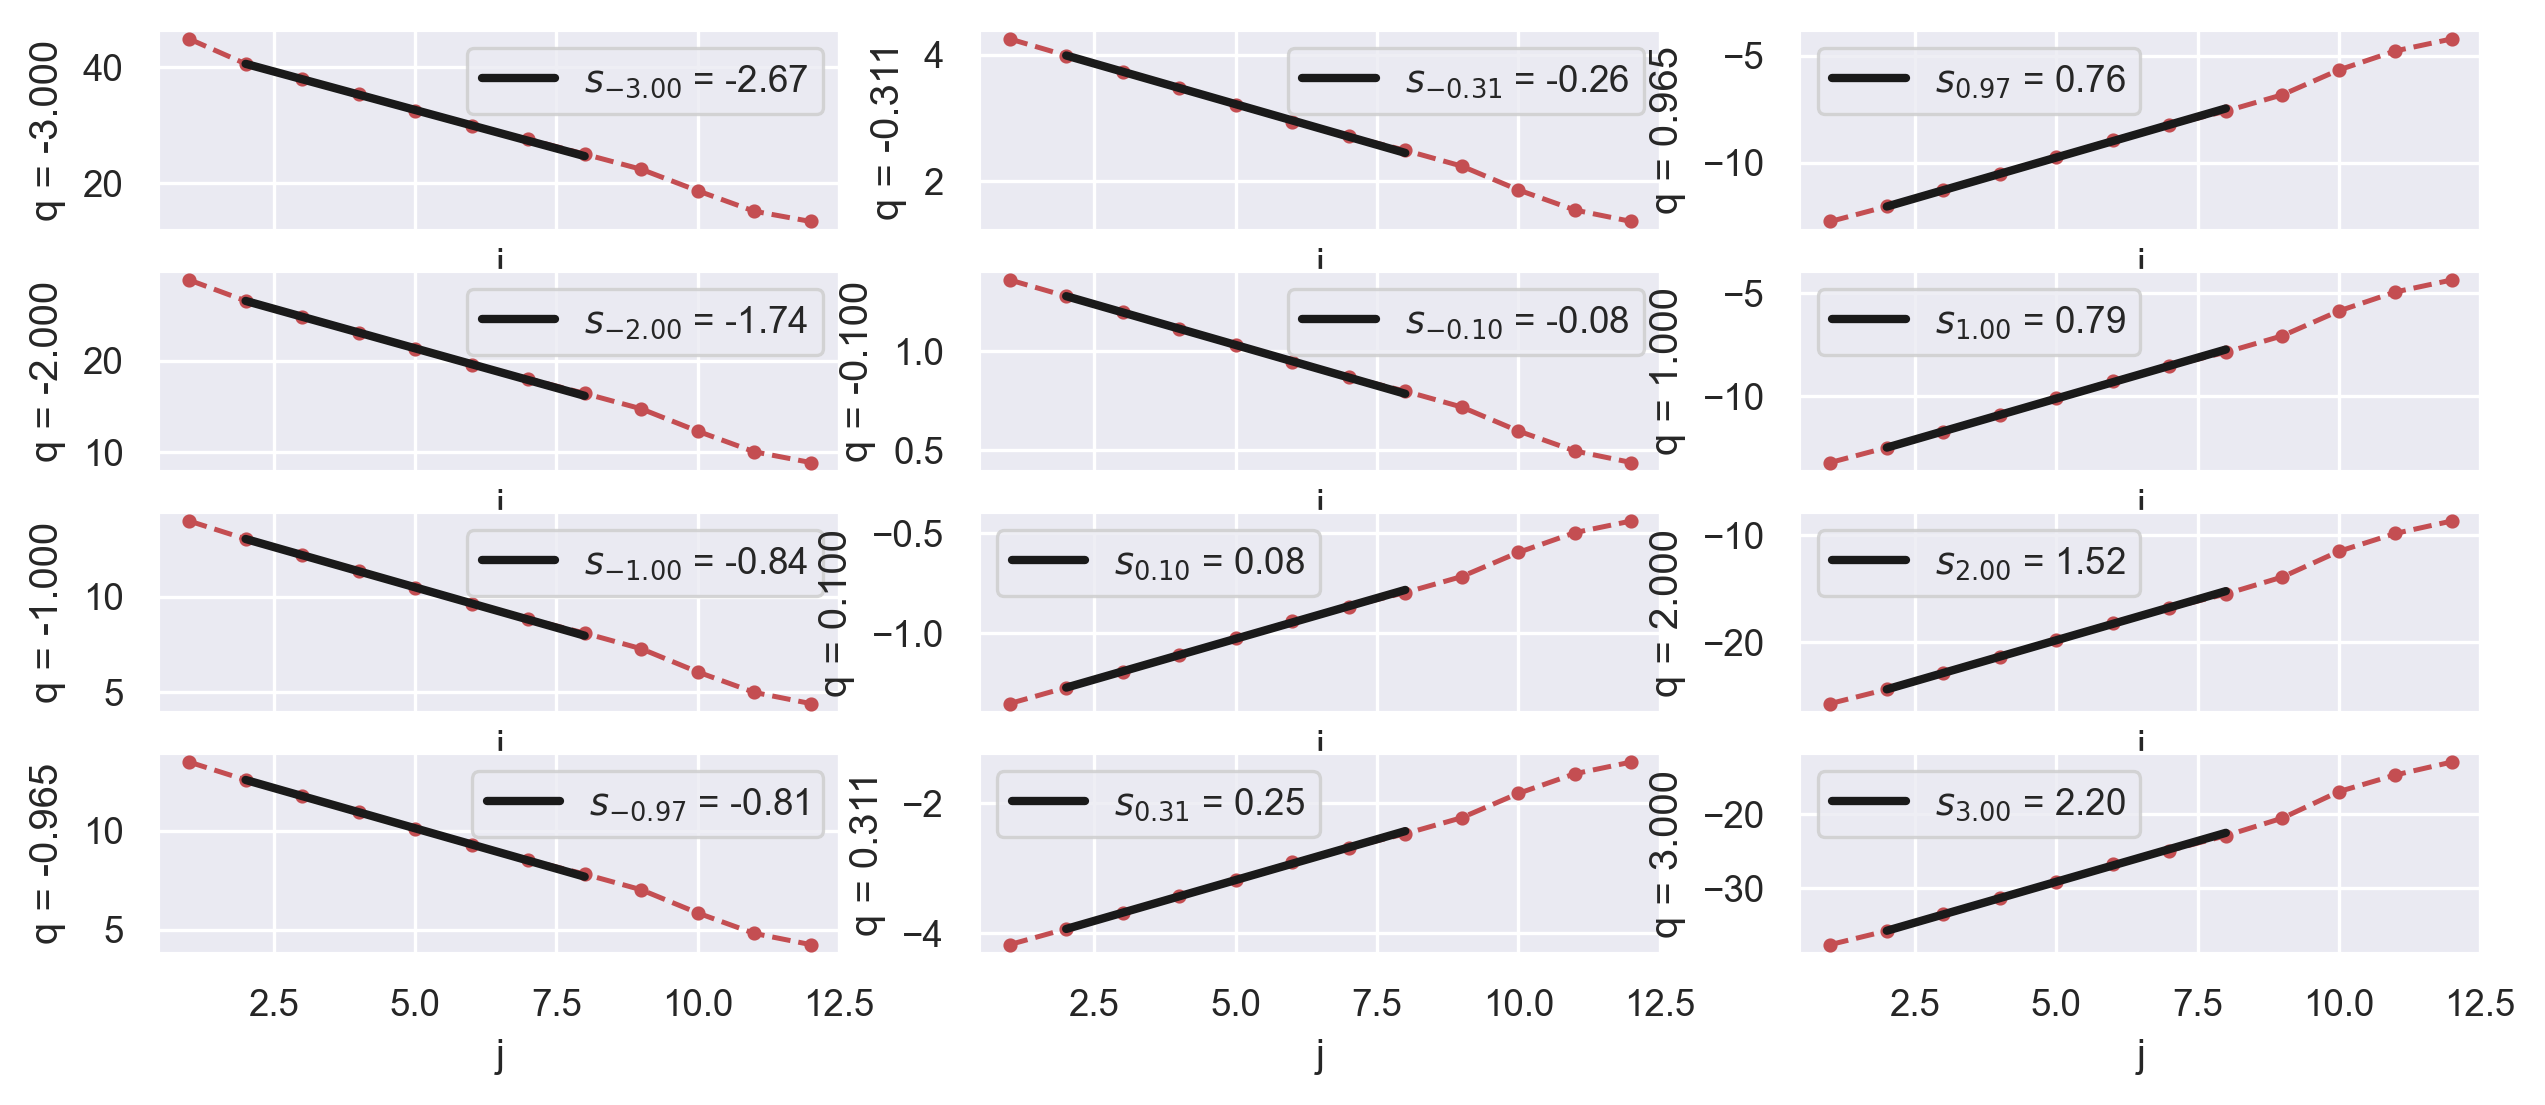

In [13]:
lwt.structure.plot(figsize=(10, 4))

We can plot $\zeta(q)$ using the `.plot_scaling` method

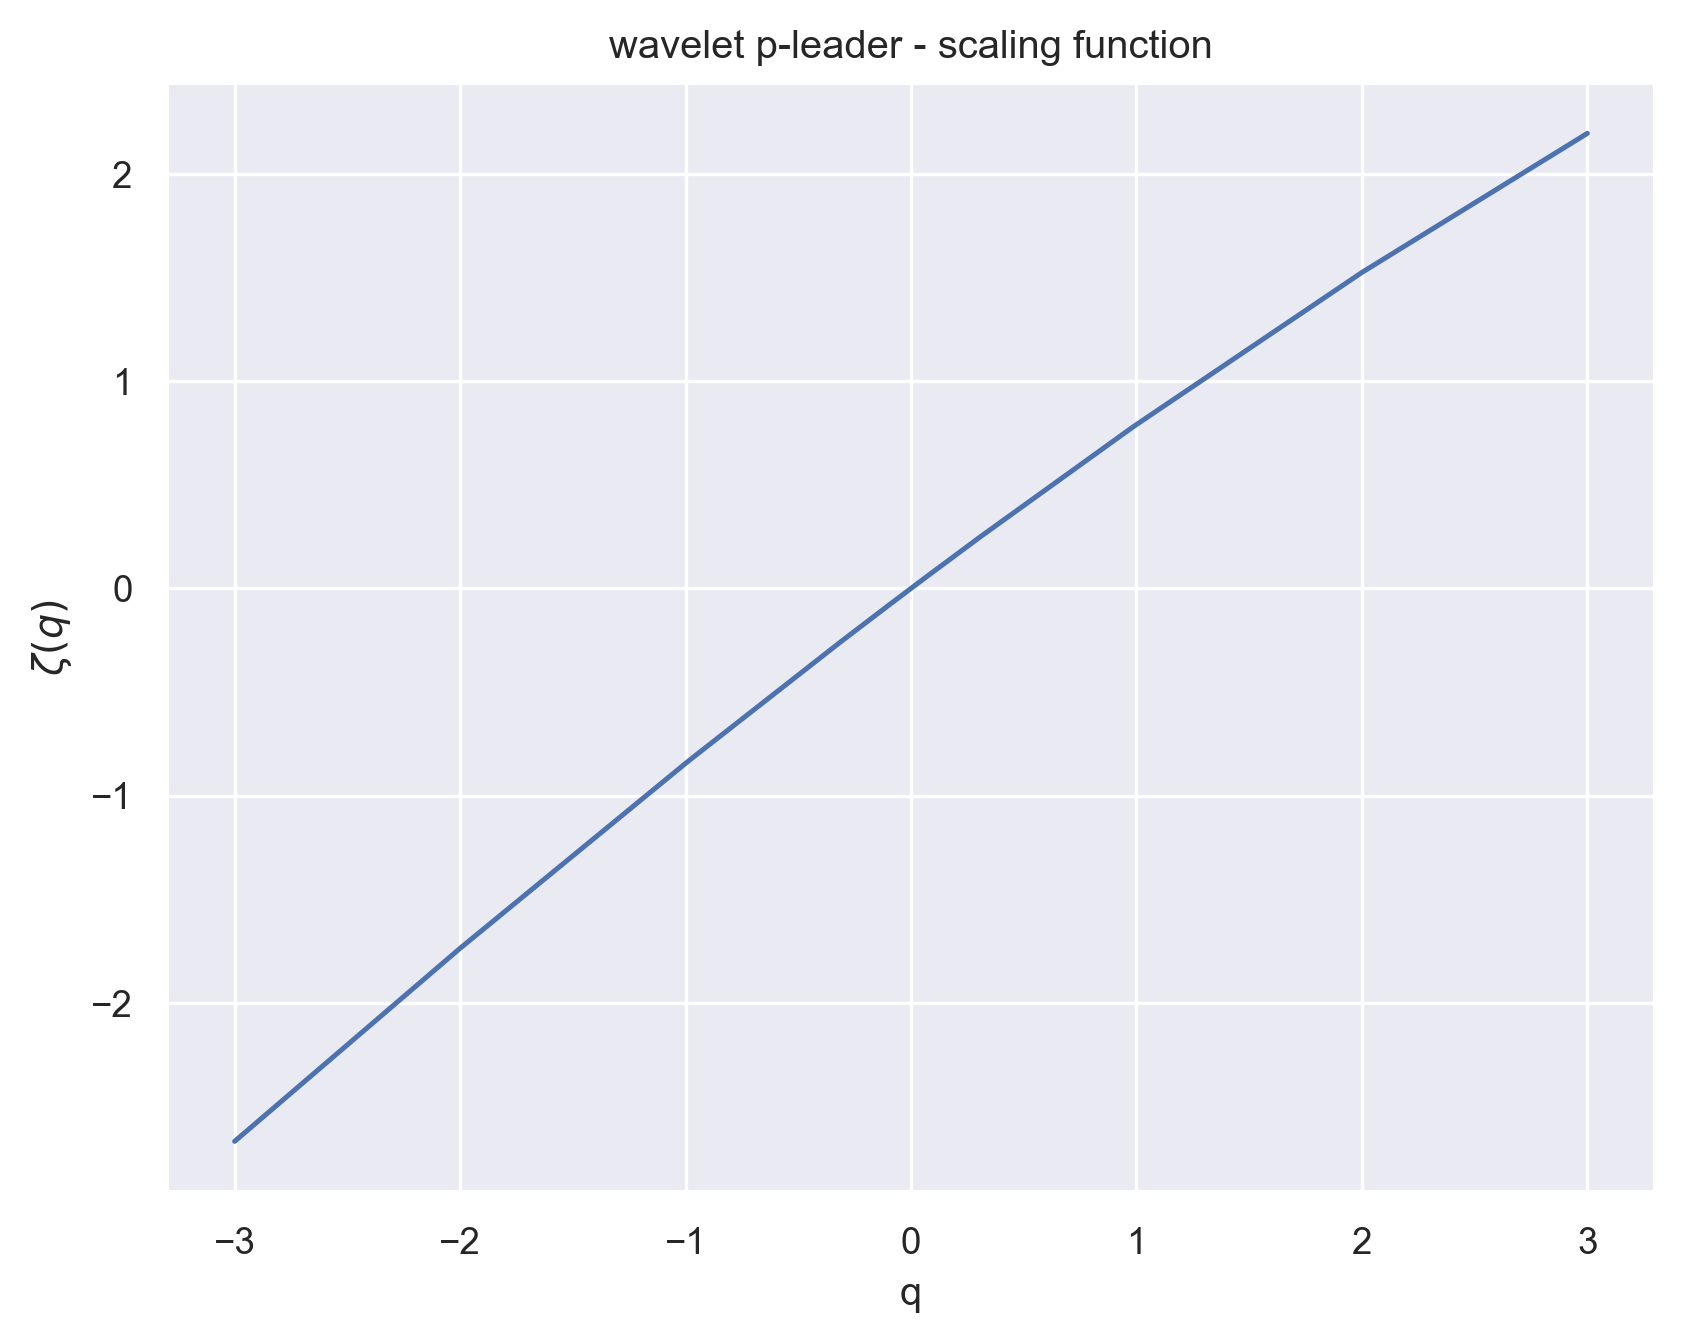

In [14]:
lwt.structure.plot_scaling()

#### Cumulants

The cumulant scaling functions may be visualized using 

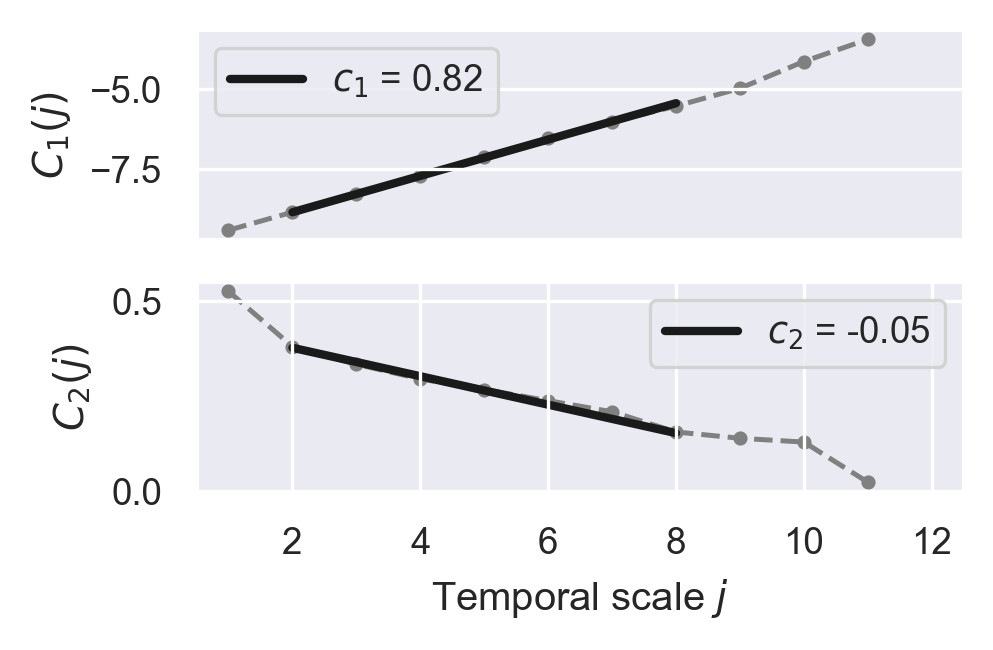

In [15]:
lwt.cumulants.plot()

#### Multifractal spectrum

Visualizing the multifractal spectrum requires more densely sampled values of $q$:

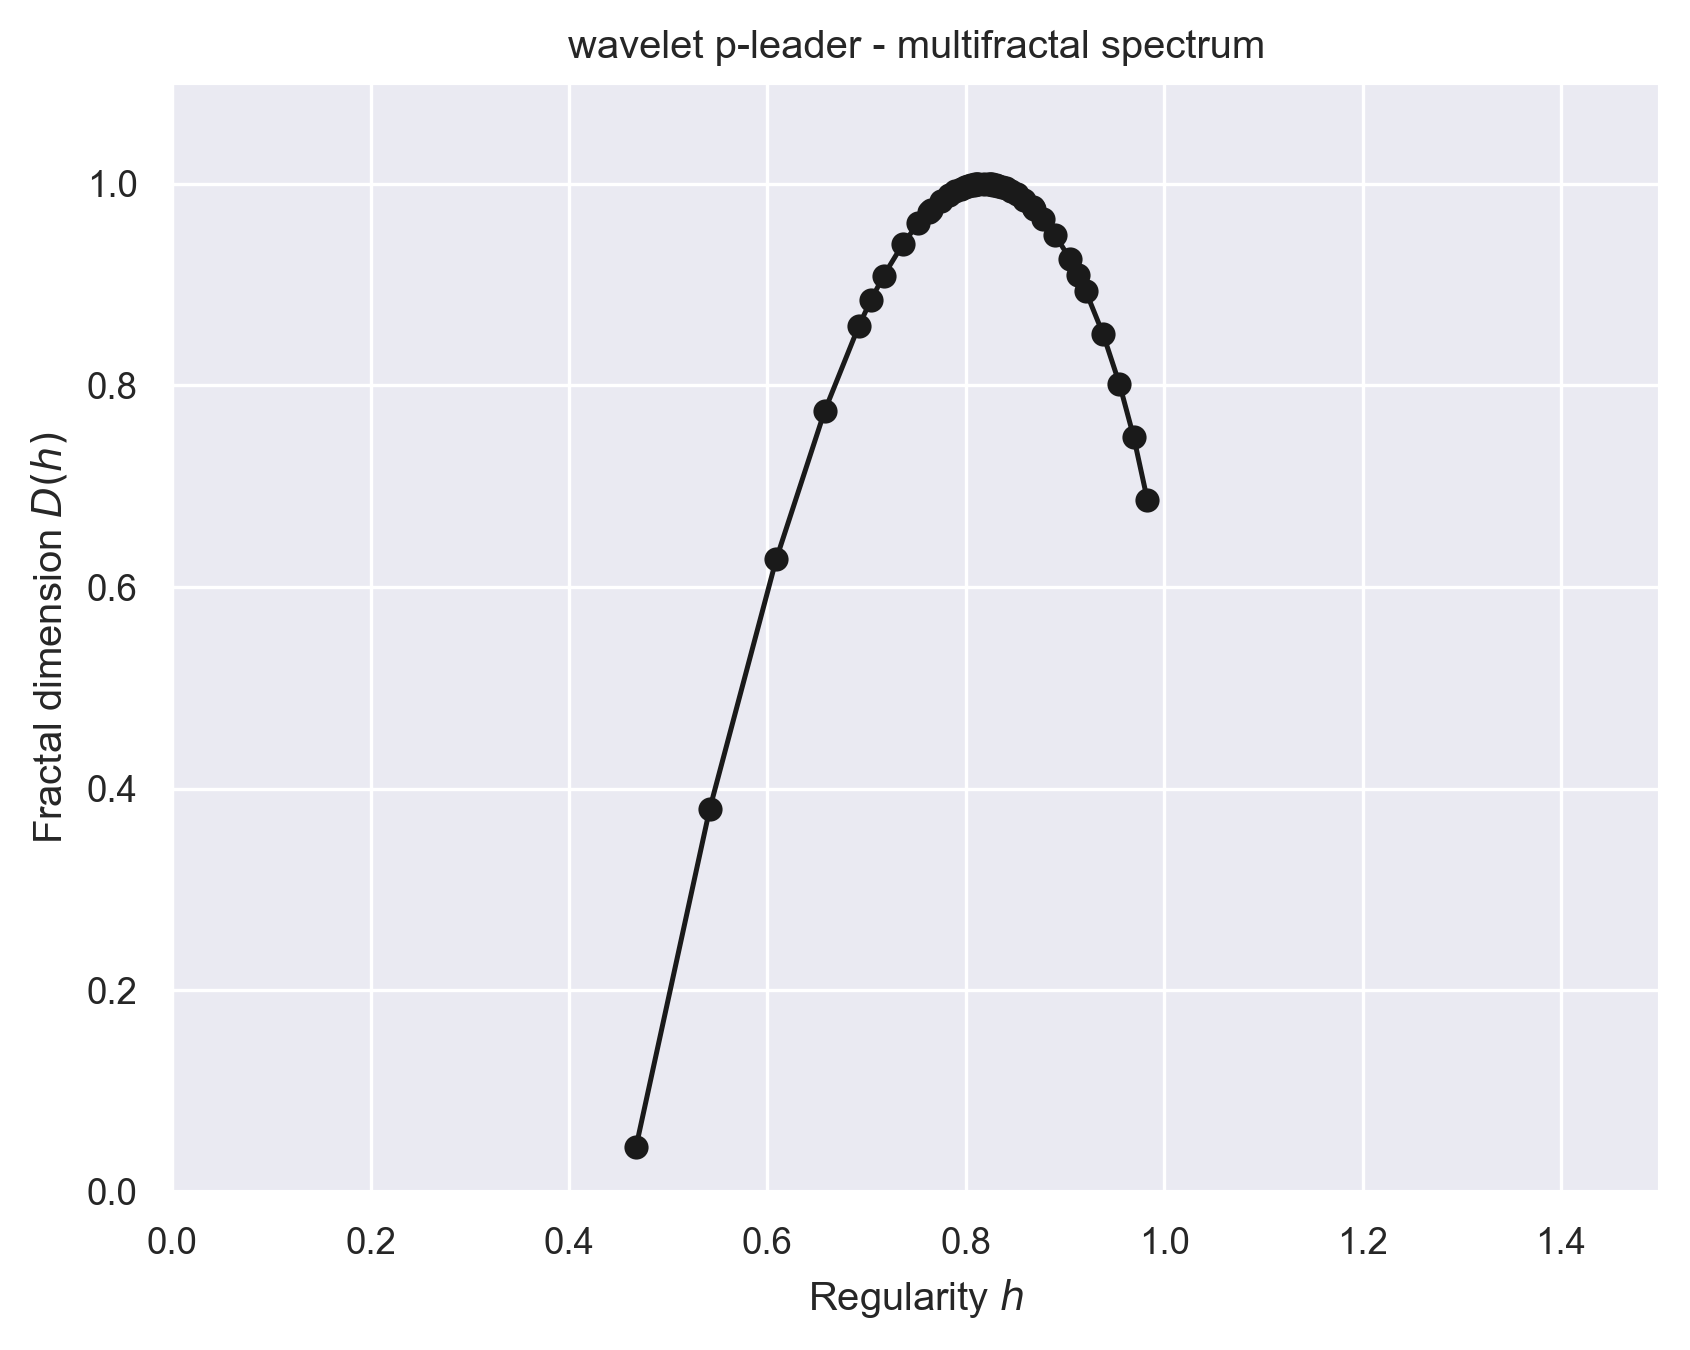

In [16]:
lwt = mfa(WTpL, scaling_ranges, weighted='Nj', q=build_q_log(.1, 5, 20))

lwt.spectrum.plot()